In [1]:
%pylab inline

import numpy as np
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Face recognition

The goal of this seminar is to build two simple (anv very similar) face recognition pipelines using **`scikit-learn`** package. Overall, we'd like to explore different representations and see which one works better. 

## Prepare dataset

In [2]:
import scipy.io

image_h, image_w = 32, 32

data = scipy.io.loadmat('faces_data.mat')

X_train = data['train_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_train = data['train_labels'] - 1
X_test = data['test_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_test = data['test_labels'] - 1

n_features = X_train.shape[1]
n_train = len(y_train)
n_test = len(y_test)
n_classes = len(np.unique(y_train))

print('Dataset loaded.')
print('  Image size        : {}x{}'.format(image_h, image_w))
print('  Train images      : {}'.format(n_train))
print('  Test images       : {}'.format(n_test))
print('  Number of classes : {}'.format(n_classes))

Dataset loaded.
  Image size        : 32x32
  Train images      : 280
  Test images       : 120
  Number of classes : 40


Now we are going to plot some samples from the dataset using the provided helper function.

In [3]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, interpolation='nearest')
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

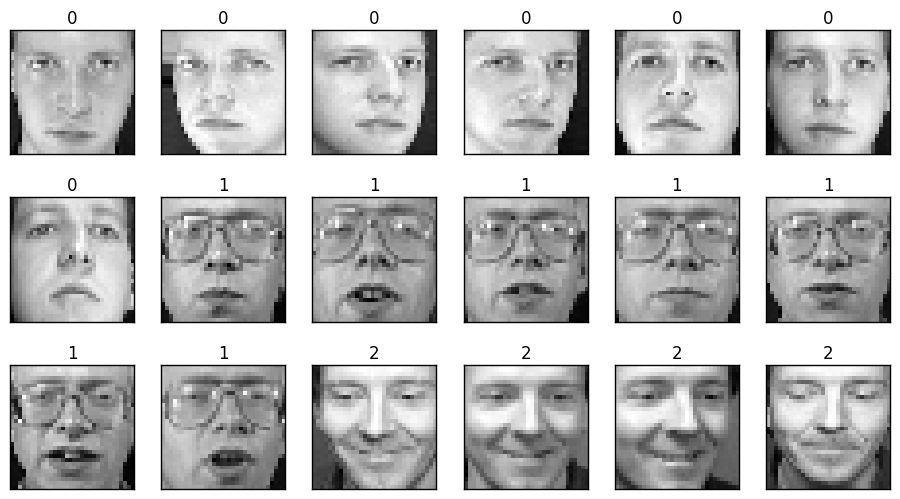

In [4]:
titles = [str(y[0]) for y in y_train]

plot_gallery(X_train, titles, image_h, image_w)

## Nearest Neighbour baseline

In [5]:
# cast type & reshape

X_train = X_train.astype("float64")
X_test = X_test.astype("float64")

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

The simplest way to do face recognition is to treat raw pixels as features and perform **Nearest Neighbor Search** in the Euclidean space. Let's use **`KNeighborsClassifier`** class.

In [6]:
from sklearn.neighbors import KNeighborsClassifier

# Use KNeighborsClassifier to calculate test score for the Nearest Neighbour classifier.

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print('Test score: {}'.format(knn.score(X_test, y_test)))

Test score: 0.783333333333


Not very imperssive, is it?

## Eigenfaces

All the dirty work will be done by the scikit-learn package. First we need to learn a dictionary of codewords. For that we preprocess the training set by making each face normalized (zero mean and unit variance)..

In [7]:
# Populate variable 'X_train_processed' with samples each of which has zero mean and unit variance.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)


X_train_processed = scaler.transform(X_train)
X_test_processed = scaler.transform(X_test)

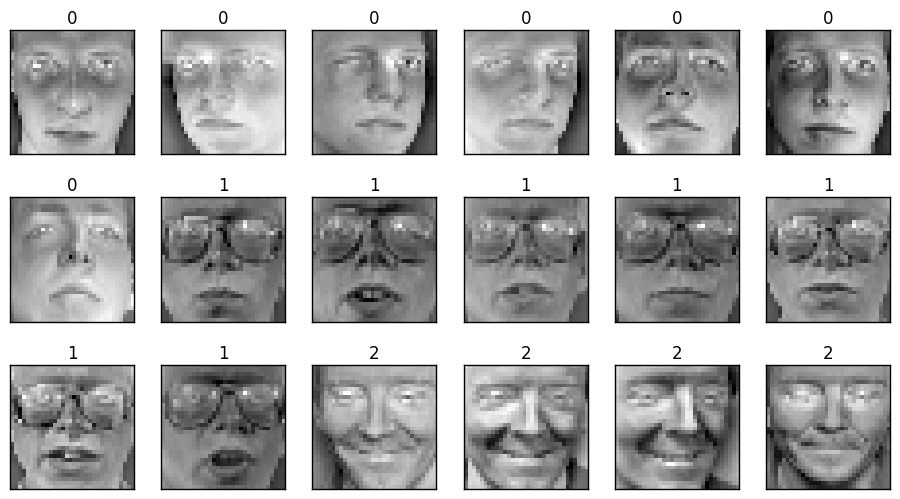

In [8]:
plot_gallery(X_train_processed, y_train, image_h, image_w)

Now we are going to apply **PCA** to obtain a dictionary of codewords. 
**`RamdomizedPCA`** class is what we need.

In [9]:
from sklearn.decomposition import PCA

n_components = 64

# Populate 'pca' with a trained instance of RamdomizedPCA.

pca = PCA(n_components=n_components, iterated_power=100, svd_solver='randomized')
pca.fit(X_train_processed)

PCA(copy=True, iterated_power=100, n_components=64, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

We plot a bunch of principal components.

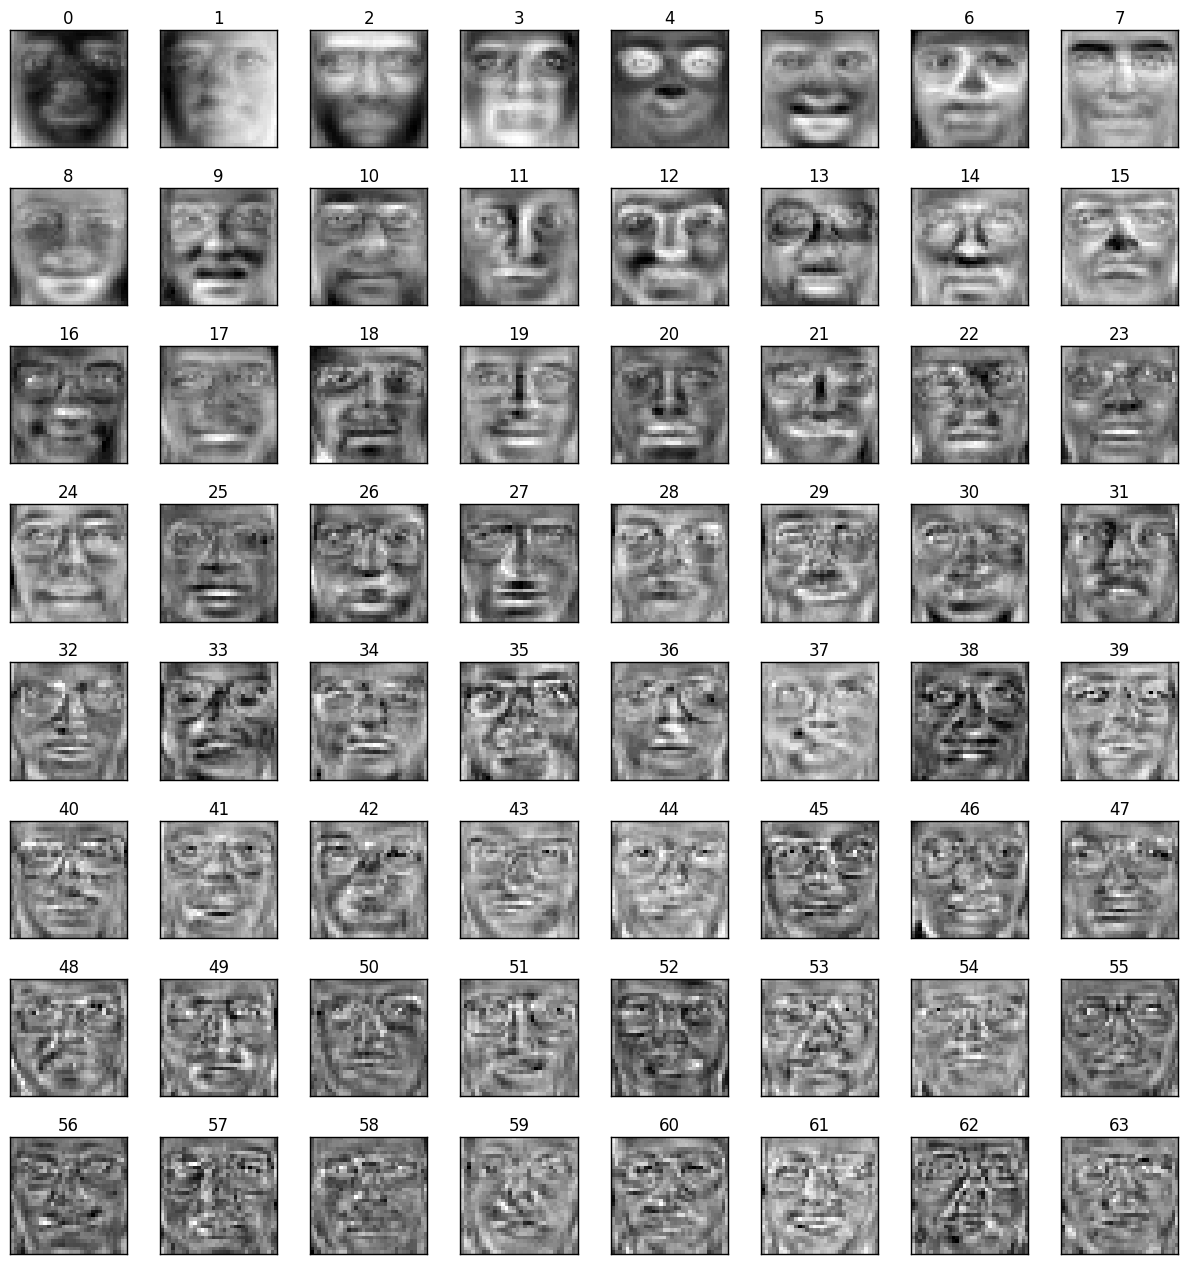

In [10]:
# Visualize principal components.

im_size = int(n_components ** 0.5)
plot_gallery(pca.components_, range(pca.components_.shape[0]), image_h, image_w, n_row=8, n_col=8)

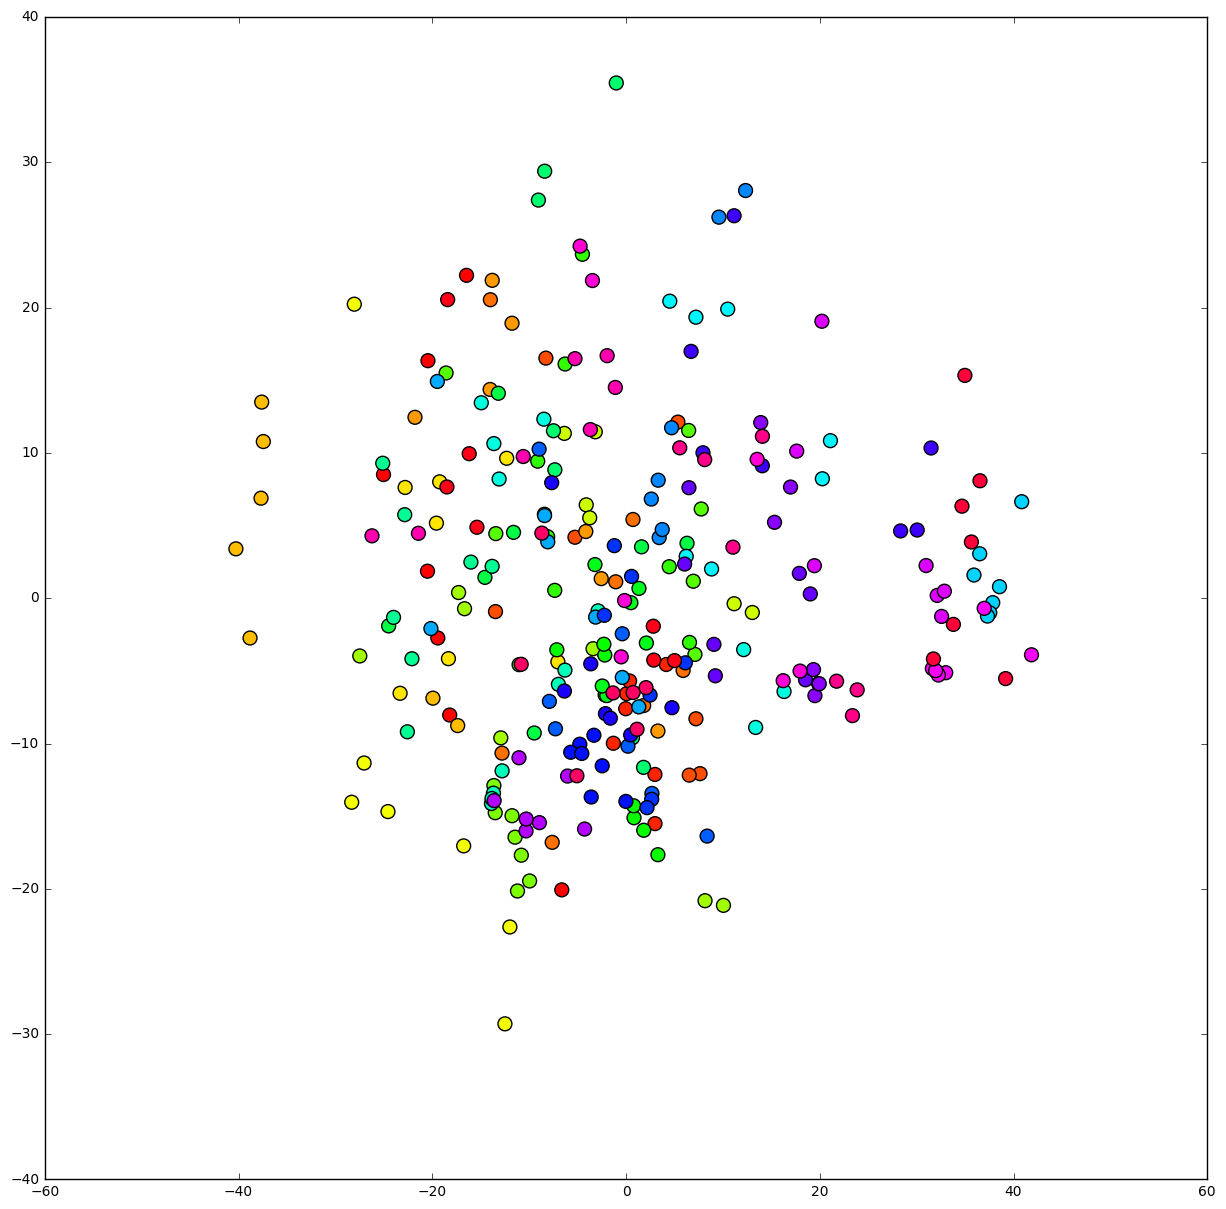

In [12]:
# x, y - main components (max eigenvalues)

import matplotlib.cm as cmx
import matplotlib.colors as colors

def get_cmap(n):
    color_norm  = colors.Normalize(vmin=0, vmax=n-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='hsv')
    
    return {idx: scalar_map.to_rgba(idx) for idx in range(n)}

color_map = get_cmap(n_classes)
colors = [color_map[i] for i in y_train]
x, y = pca.transform(X_train_processed)[:,:2].T

plt.figure(figsize=(15, 15))
plt.scatter(x, y, c=colors, s=100)

This time we don't have any restriction on number of non-zero coefficients in the vector decomposition, so the codes are not sparse anymore:

In [13]:
# Transform training data and plot decomposition coefficients.

X_train_pca = pca.transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)
pca.components_

array([[-0.0071033 , -0.01399567, -0.01955117, ..., -0.00473119,
         0.00392238,  0.00758575],
       [-0.04123207, -0.05069528, -0.05773115, ...,  0.04400596,
         0.04497191,  0.03782816],
       [ 0.00249207,  0.00157839,  0.00685079, ..., -0.03013099,
        -0.01983841, -0.01568102],
       ..., 
       [ 0.01037376, -0.01731605, -0.02903089, ...,  0.03757867,
         0.00680257, -0.03533779],
       [ 0.05929335,  0.06537008,  0.00768839, ..., -0.03568413,
        -0.05154729, -0.02670162],
       [ 0.00718092,  0.00081603,  0.02079668, ...,  0.01264369,
        -0.01970527,  0.03740169]])

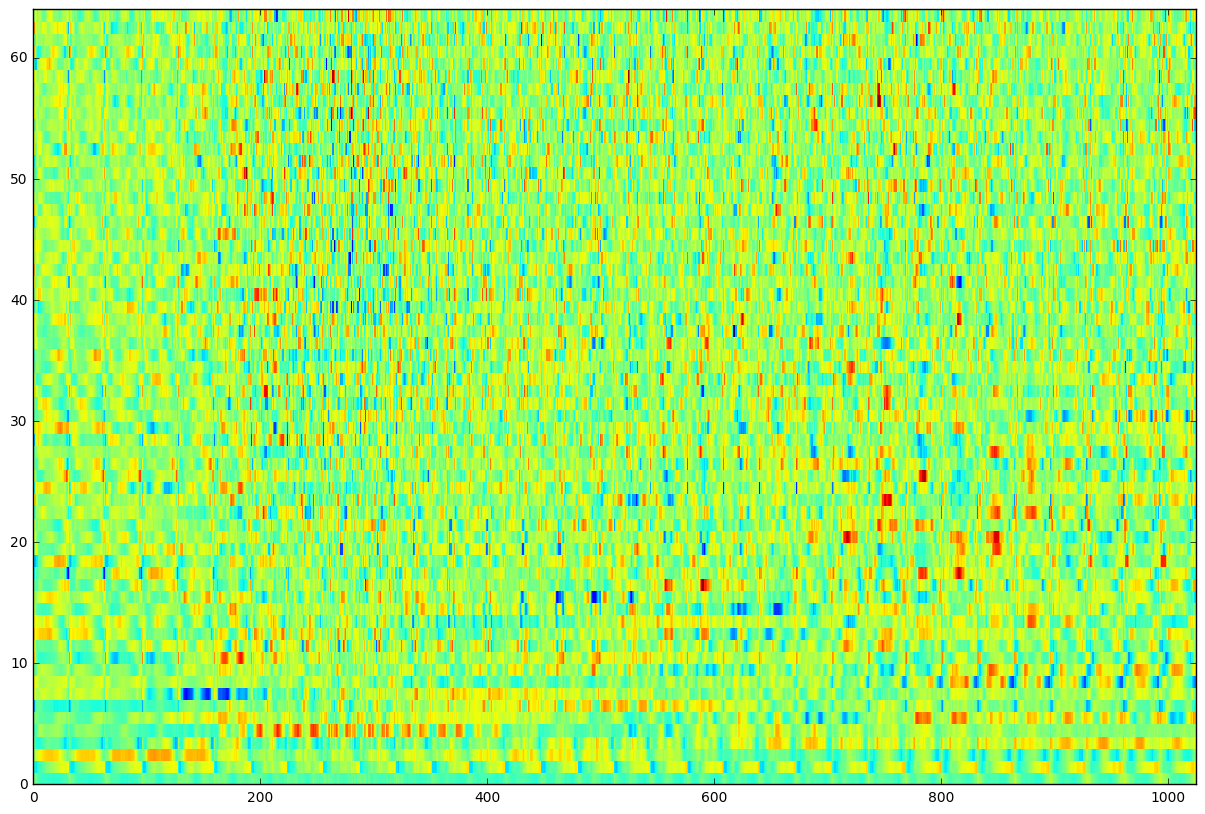

In [14]:
plt.figure(figsize=(15, 10))
plt.axis([0, pca.components_.shape[1], 0, pca.components_.shape[0]])
plt.pcolor(pca.components_, cmap="jet")

plt.show()

Train an SVM and apply it to the encoded test data.

In [15]:
from sklearn.svm import LinearSVC

# Populate 'test_score' with test accuracy of an SVM classifier.

svm = LinearSVC()
svm.fit(X_train_pca, y_train)

print('Test score: {}'.format(svm.score(X_test_pca, y_test)))

Test score: 0.958333333333


How many components are sufficient to reach the same accuracy level?

Max accuracy: 0.95


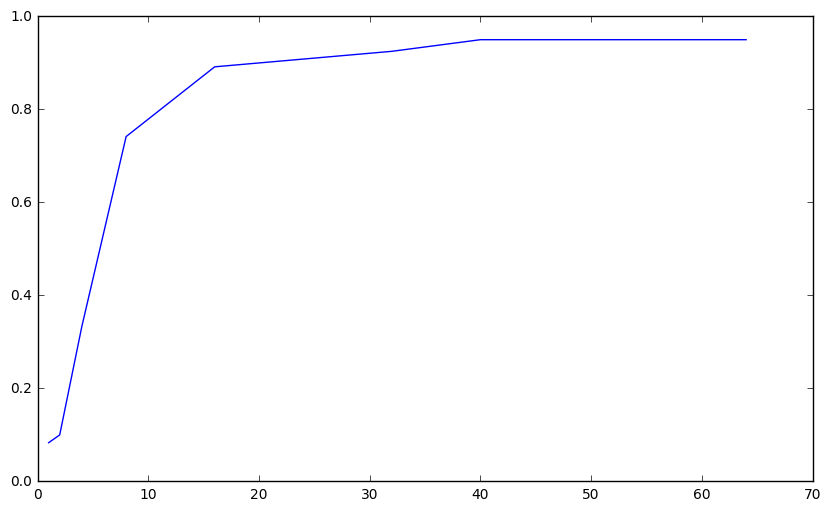

In [16]:
n_components = [1, 2, 4, 8, 16, 24, 32, 40, 48, 56, 64]
accuracy = []

# Try different numbers of components and populate 'accuracy' list.

for n_comp in n_components:
    svm = LinearSVC()
    svm.fit(X_train_pca[:,:n_comp], y_train)
    accuracy.append(svm.score(X_test_pca[:,:n_comp], y_test))

plt.figure(figsize=(10, 6))
plt.plot(n_components, accuracy)

print('Max accuracy: {}'.format(max(accuracy)))